In [66]:
import numpy as np
import scipy as sp
import scipy.stats as st
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib as mp
import matplotlib.pyplot as plt
# force inline plots
%matplotlib inline
plt.style.use('seaborn-deep')
import torch.nn as nn
import copy


In particle physics, the most important experiment is a counting experiment, represented by a Poisson probability model, where $N$ is the observed count and $\theta$ is a nuissance parameter, hence the probability model is $P(N|\theta) = \text{Poisson}(N,\theta)$.
where the most important parameter is the cross section $\sigma$, which is related to the mean event count 

$$\mu = \sigma \mathcal{L} +b$$

(more fully it is $\mu = \varepsilon \sigma \mathcal{L} +b$ where $\varepsilon = \prod_i \varepsilon_i$ is the product of all the efficiencies for the signal). Here the interesting parameter is only the cross section, whereas $\mathcal{L}, \ b$ are nuissance parameters. In a Bayesian context, one could eliminate the nuissance parameters by marginalization, i.e. by integrating the probability with respect to the nuissance parameters.

$$ P(N, \mathcal{L}, b| \sigma, \mathcal{L}_{truee}, b_{true}) =L(\sigma, \mathcal{L}_{truee}, b_{true})= \frac{e^{-(\sigma \mathcal{L} +b)}(\sigma \mathcal{L} +b)^N}{N !} \ Gamma(\mathcal{L}_{true}) \ Gamma(b_{true})$$

Therefore we have 3 pieces of data:

* Observed count $N$
* the estimated luminosity
* The estimated background

We also have 3 parameters:
* The cross section $\sigma$
* The true luminosity $\mathcal{L}$
* The true background $b$

We want to construct a test to that the probability of making a type I error (rejecting the null hypothesis when it is true) is bounded, it cannot be larger than $\alpha$. This is done by defining a critical region $R(D)$ where $D$ is the observed data, which is composed of all the values of $\theta$ that are not rejected by the test $\delta$

$$ R(D) = \{ \theta_0 \in \Theta \mid \text{test } \delta_{\theta_o} \text{ does not reject the null hypothesis} \}$$

# Starting Simple: Using Algorithm 2 to calculate the $p$-value of a Poisson distribution.

We start with the very simple likelihood 
$$L(\theta) = \frac{e^{-\theta} \theta^N}{N !}$$

In [21]:
Bprime=10000
D = 10
L_obs=30 
#b= mean background
print('The size of B: ', Bprime)
print('The observed signal signal D or N: ', D)
print('The observed luminosity: ', L_obs)
# print('The observed background'

The size of B:  10000
The observed signal signal D or N:  10
The observed luminosity:  30


Note that $D$ is only a constant and appeard only in the calculation of the test statistic $\lambda (D, \theta_0)$

Test statistic could be the likelihood ratio, which is the ratio of the likelihood to the profiled likelihood (likelihood computed at an MLE estimate of one of the parameters), or $t=-2log (this ratio)$

### Test statistic $\lambda$

We have several options for this statistic, such as the likelihood ratio, etc. as is shown by Ann Lee's paper. In our case we'd probably like to use the likelihood ratio

In [12]:
def lambd(D, theta, thetahat=1):#test statistic
    L_num = st.norm.pdf(D, loc= theta, scale=1)#the gaussian pdf of D counts
    return L_num

For our simple example we draw a single $X ~ F_{\theta}$

In [13]:
#T=[[theta_i],[Z_i]]
T = [[],[]]
for i in range(Bprime):
    theta = round(np.random.normal(10))#draw a count theta from a radom poisson prior, it has to be count because its an input to a poisson. This prior should also be close to the cound D
    X_mean = np.random.poisson(lam=theta) #draw count samples randomly from a poisson distribution
    lam_true = lambd(D, theta)
    lam_i = lambd(X_mean, theta)
    if lam_i < lam_true:
        Z_i=1
    else:
        Z_i=0
    T[0].append(theta)
    T[1].append(Z_i)

$\widehat{\mathbb{E}}[Z \mid \theta] = \frac{N_{Z=1}}{N_{Z, \ total}}$

In [14]:
def E_hat(T):
    """The expectation value of Z as a relative frequency, this should equal p_hat, the learned parameterized distribution at a given theta"""
    num = np.array(T[1]).sum()
    den = Bprime
    return num/den

In [15]:
E_hat(T)

0.6959

The actual p-value is $p = \int P(N|\theta) d\theta$ or in our case $p=\sum_{k=D}^{\infty} \text{Poisson}(k|\theta) = scipy.special.gammainc(D, \theta)$

In [16]:
def p_calculated(theta):
    return sp.special.gammainc(D, theta)

In [23]:
p = p_calculated(theta = round(np.random.normal(10))); p

0.6594893575343392

In [18]:
np.random.gamma(5)

11.185435114067817

train_dataset[0]Now that we've built up the dataset, we now need to learn the function $\hat{p}(D;\theta)=\hat{p}(\theta)$ which is the output of a machine learning regression model, where the training data are $\vec{\theta}, \vec{Z}$ so that the target is $Z$ and the (input) features is $\theta$, so that the NN model's only parameter is $\theta$, not $D$ because it's just a fixed constant.
## Pytorch Regression Model

In [27]:
data, targets = np.array(T[0]), np.array(T[1])

In [33]:
ntargets = 1
from sklearn.model_selection import train_test_split
train_data, test_data, train_targets, test_targets = train_test_split(data, 
                                                                      targets, 
                                                                      stratify=targets)
#Reshape the targets to have shape (something, 1)
train_targets = train_targets.reshape(-1,1)
test_targets = test_targets.reshape(-1,1)
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)
print(test_targets, test_data)

[[0]
 [1]
 [0]
 ...
 [0]
 [1]
 [0]] [[10]
 [ 9]
 [ 8]
 ...
 [12]
 [11]
 [ 9]]


In [34]:
sc = StandardScaler()#this is always recommended for logistic regression
train_data= sc.fit_transform(train_data)
test_data = sc.transform(test_data)
train_data.mean(), (train_data.std())**2#check to make sure mean=0, std=1

(2.0368891758456205e-16, 1.0)

In [59]:
import mymodels #this library can be found at https://github.com/AliAlkadhim/MyMLFramework/blob/main/mymodels.py
mymodels.CustomDataset.__doc__

'This takes the index for the data and target and gives dictionary of tensors of data and targets.\n    For example we could do train_dataset = CustomDataset(train_data, train_targets); test_dataset = CustomDataset(test_data, test_targets)\n where train and test_dataset are np array that are reshaped to (-1,1)'

In [38]:
from mymodels import CustomDataset
train_dataset = CustomDataset(train_data, train_targets)
test_dataset = CustomDataset(test_data, test_targets)
train_dataset[0]

{'x': tensor([0.9755]), 'y': tensor([1.])}

In [39]:

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=10, 
                                           num_workers=2, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=10, num_workers=2)

Compare with Directly computing the $p$-value for the Poisson distribution $PoisS(D|\lambda=\theta_0)$. So say we use counts $D=0....20$, then we have 20 jobs running in parallel, each working on a different value of $D$. It might be worth generalizing it so that the model is a parameterized function of both $\theta$ and $D$.

For our case, the goal is to generalize step 3, where we have 3 parameters as opposed to 1, $\theta =\{\sigma, \mathcal{L}, b \}$ so that we'd have priors for each of these parameters, so at the end, at a fixed $D$, we'd have the output being the p-value being a function of all 3 $\hat{p}(D; \sigma, \mathcal{L}, b)$. Then we can use section 3.4 to construct the confidence interval for the cross section that properly takes into account the two nuissance parameters $\mathcal{L}, b$

In [51]:
# from mymodels import RegressionModel
class RegressionModel(nn.Module):
    def __init__(self, nfeatures, ntargets, nlayers, hidden_size, dropout):
        super().__init__()
        layers = []
        for _ in range(nlayers):
            if len(layers) ==0:
                #inital layer has to have size of input features as its input layer
                #its output layer can have any size but it must match the size of the input layer of the next linear layer
                #here we choose its output layer as the hidden size (fully connected)
                layers.append(nn.Linear(nfeatures, hidden_size))
                #batch normalization
                layers.append(nn.BatchNorm1d(hidden_size))
                layers.append(nn.Dropout(dropout))
                #ReLU activation 
                layers.append(nn.ReLU())
            else:
                #if this is not the first layer (we dont have layers)
                layers.append(nn.Linear(hidden_size, hidden_size))
                layers.append(nn.BatchNorm1d(hidden_size))
                layers.append(nn.Dropout(dropout))
                layers.append(nn.ReLU())
                #output layer:
        layers.append(nn.Linear(hidden_size, ntargets)) 
        
        layers.append(nn.Sigmoid())
            #we have defined sequential model using the layers in oulist 
        self.model = nn.Sequential(*layers)
            
    
    def forward(self, x):
        return self.model(x)

In [52]:
model =  RegressionModel(nfeatures=train_data.shape[1], 
               ntargets=1,
               nlayers=5, 
               hidden_size=128, 
               dropout=0.3)
print(model)

RegressionModel(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.3, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.3, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=128, out_features=128, bias=True)
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout(p=0.3, inplace=False)
    (15): ReLU()
    (16): Linear(in_features=128, out_features=128, bias=True)
    (17): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, 

In [62]:
class RegressionEngine:
    """loss, training and evaluation"""
    def __init__(self, model, optimizer):
                 #, device):
        self.model = model
        #self.device= device
        self.optimizer = optimizer
        
    #the loss function returns the loss function. It is a static method so it doesn't need self
    @staticmethod
    def loss_fun(targets, outputs):
         return nn.MSELoss()(outputs, targets)


    def train(self, data_loader):
        """the training function: takes the training dataloader"""
        self.model.train()
        final_loss = 0
        for data in data_loader:
            self.optimizer.zero_grad()
            inputs = data["x"]#.to(self.device)
            targets = data["y"]#.to(self.device)
            outputs = self.model(inputs)
            loss = self.loss_fun(targets, outputs)
            loss.backward()
            self.optimizer.step()
            final_loss += loss.item()
            return final_loss / len(data_loader)

    
    def evaluate(self, data_loader):
        """the training function: takes the training dataloader"""
        self.model.eval()
        final_loss = 0
        for data in data_loader:
            inputs = data["x"]#.to(self.device)
            targets = data["y"]#.to(self.device)
            outputs = self.model(inputs)
            loss = self.loss_fun(targets, outputs)
            final_loss += loss.item()
            return outputs
            #return final_loss / len(data_loader)

In [63]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
eng = RegressionEngine(model=model, optimizer = optimizer)
best_loss = np.inf
early_stopping_iter = 10
early_stopping_counter = 0
EPOCHS=22

In [64]:
for epoch in range(EPOCHS):
    train_loss = eng.train(train_loader)
    test_loss = eng.train(test_loader)
    print("Epoch : %-10g, Training Loss: %-10g, Test Loss: %-10g" % (epoch, train_loss, test_loss))
    #print(f"{epoch}, {train_loss}, {test_loss}")
    if test_loss < best_loss:
        best_loss = test_loss
        
    else:
        early_stopping_counter += 1
    
    if early_stopping_counter > early_stopping_iter:
        #if we are not improving for 10 iterations then break the loop
        #we could save best model here
        break

Epoch : 0         , Training Loss: 0.000408847, Test Loss: 0.00105222
Epoch : 1         , Training Loss: 0.00028409, Test Loss: 0.000915958
Epoch : 2         , Training Loss: 0.000286773, Test Loss: 0.000869398
Epoch : 3         , Training Loss: 0.000402892, Test Loss: 0.00144139
Epoch : 4         , Training Loss: 0.000307841, Test Loss: 0.000986041
Epoch : 5         , Training Loss: 0.00034197, Test Loss: 0.00076567
Epoch : 6         , Training Loss: 0.000310439, Test Loss: 0.000989265
Epoch : 7         , Training Loss: 0.000297197, Test Loss: 0.000813849
Epoch : 8         , Training Loss: 0.000384276, Test Loss: 0.00094127
Epoch : 9         , Training Loss: 0.000251631, Test Loss: 0.000587939
Epoch : 10        , Training Loss: 0.000477164, Test Loss: 0.000555949
Epoch : 11        , Training Loss: 0.000343835, Test Loss: 0.000746557
Epoch : 12        , Training Loss: 0.000372936, Test Loss: 0.000922841
Epoch : 13        , Training Loss: 0.000325631, Test Loss: 0.000758718
Epoch : 14  

In [68]:
outputs = []
labels = []
accuracies = []

#evaluate
with torch.no_grad():
    for data in test_loader:
        data_cp = copy.deepcopy(data)
        
        xtest = data_cp["x"]
        ytest = data_cp["y"]
        output = model(xtest)
        labels.append(ytest)
        outputs.append(output)
        
        y_predicted_cls = output.round()
        acc = y_predicted_cls.eq(ytest).sum() / float(ytest.shape[0])#bumber of correct predictions/sizeofytest
        #accuracies.append(acc.numpy())
        #print(f'accuracy: {acc.item():.4f}')
        
        del data_cp

#     acc = y_predicted_cls.eq(ytest).sum() / float(ytest.shape[0])
#     print(f'accuracy: {acc.item():.4f}')
outputs[0:2]

[tensor([[0.5863],
         [0.3795],
         [0.2159],
         [0.3967],
         [0.7747],
         [0.7936],
         [0.6855],
         [0.7426],
         [0.3960],
         [0.7034]]),
 tensor([[0.5861],
         [0.8277],
         [0.7988],
         [0.6008],
         [0.8735],
         [0.4286],
         [0.6666],
         [0.6455],
         [0.6496],
         [0.0751]])]

[0.58625966 0.3795342  0.21585454 ... 0.85125905 0.8080859  0.63989043] [0. 1. 0. ... 0. 1. 0.]


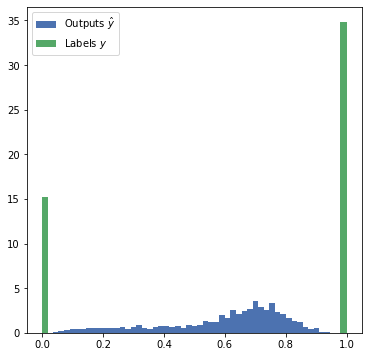

In [70]:
OUTPUTS = torch.cat(outputs).view(-1).numpy()

LABELS = torch.cat(labels).view(-1).numpy()
print(OUTPUTS, LABELS)
plt.rcParams["figure.figsize"] = (6,6)
plt.hist(OUTPUTS, bins=50, density=True, label = "Outputs $\hat{y}$")
plt.hist(LABELS, bins=50,density=True, label = "Labels $y$")
plt.legend()
plt.show()

[0.73431224 0.44496882 0.18356903 ... 0.70291984 0.65752524 0.44496882]


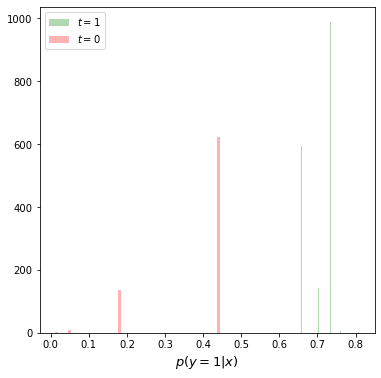

In [72]:
def compute_prob(model, xx):
    # convert from numpy array to a torch tensor of type float
    """Gives P(y=1|x)"""
    x = torch.from_numpy(xx).float()#.to(device)

    # compute p(1|x)
    model.eval() # evaluation mode
    p = model(x)#.to(device)

    # squeeze() removes extraneous dimensions
    p = p.squeeze()

    # detach().numpy() converts back to a numpy array
    p = p.detach().cpu().numpy()
    return p
p = compute_prob(model, test_data)
print(p)
plt.hist(p[p>0.5], bins=50, color='g',
            histtype='stepfilled',
            alpha=0.3,label = '$t = 1$')
plt.hist(p[p<0.5], bins=50, color='r',
            histtype='stepfilled',
            alpha=0.3,label = '$t = 0$')
plt.xlabel('$p(y=1|x)$', fontsize=13)
plt.legend()

In [ ]:
def Algorithm2(D=2, theta_0):
    
    
    
    return actual_p_value, regressed_p_value